In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from utils.Sen2_RDSR import (
    Sen2RDSR
)
from utils.loaddata import (
    Sentinel2Dataset
)
from utils.loaddatatest import (
    Sentinel2Dataset
)


In [21]:
# create model
model = Sen2RDSR()
print("Number of model parameters:", sum(p.numel() for p in model.parameters()))




Number of model parameters: 39859464


im10 shape: torch.Size([1, 4, 32, 32])
im20 shape: torch.Size([1, 6, 32, 32])
target20 shape: torch.Size([1, 2, 32, 32])
torch.Size([1, 6, 32, 32]) torch.Size([1, 2, 32, 32])


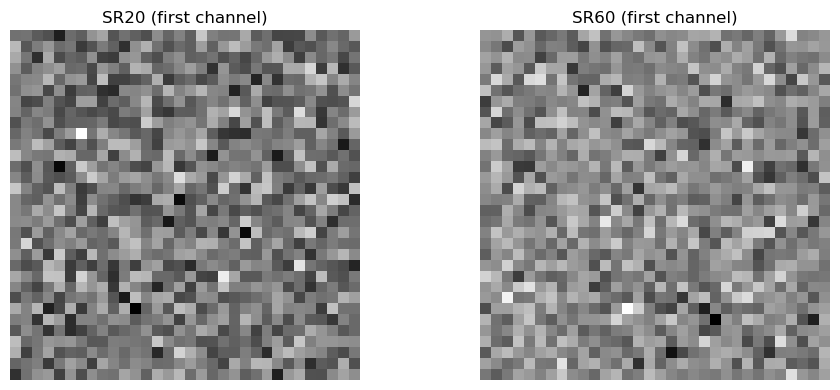

In [22]:

#print(model)
# Dummy input tensors
im10 = torch.randn(1, 4, 32, 32)       # HR bands at 10m
im20 = torch.randn(1, 6, 32, 32)        # 20m bands
im60 = torch.randn(1, 2, 32, 32)        # 60m bands

print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"target20 shape: {im60.shape}")

sr20, sr60 = model(im10, im20, im60)
print(sr20.shape, sr60.shape)  # Expect [1, 6, 60, 60] and [1, 2, 60, 60]

# Plot the first channel of sr20 and sr60 as images
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("SR20 (first channel)")
plt.imshow(sr20[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("SR60 (first channel)")
plt.imshow(sr60[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### DATALOADER

In [23]:
dataset20 = Sentinel2Dataset(dataset_type="20train")
print(f"Dataset length: {len(dataset20)}")

🔍 Detected local environment
Loading 20train data from ../data/train
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 8000


im10 shape: torch.Size([4, 32, 32])
im20 shape: torch.Size([6, 32, 32])
im60 shape: torch.Size([0])
target20 shape: torch.Size([6, 32, 32])
target60 shape: torch.Size([0])


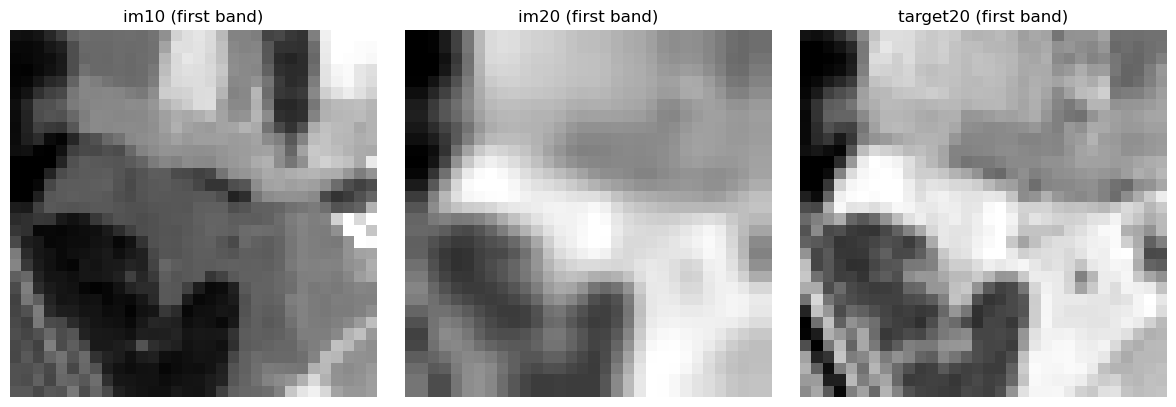

In [30]:


im10, im20, im60, target20, target60 = dataset20[0]
print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"im60 shape: {im60.shape}")
print(f"target20 shape: {target20.shape}")
print(f"target60 shape: {target60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("target20 (first band)")
plt.imshow(target20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
dataset60 = Sentinel2Dataset(dataset_type="60train")
print(f"Dataset length: {len(dataset60)}")

🔍 Detected local environment
Loading 60train data from ../data/train60
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 500


im10 shape: torch.Size([4, 96, 96])
im20 shape: torch.Size([6, 96, 96])
target20 shape: torch.Size([0])
im60 shape: torch.Size([2, 96, 96])
target60 shape: torch.Size([2, 96, 96])


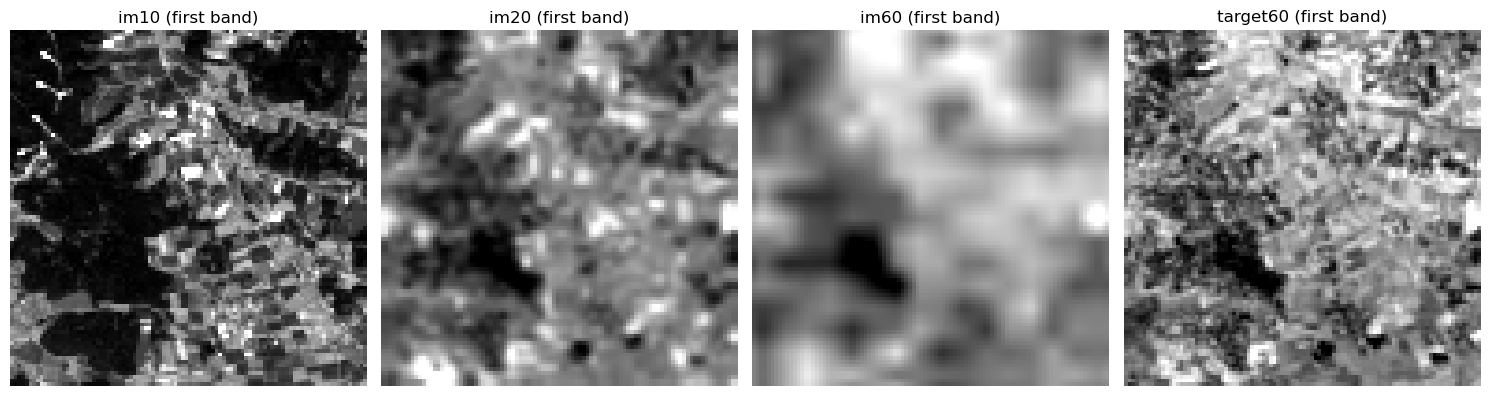

In [ ]:
# Print shapes of im10, im20, target20, im60, target60



print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"target20 shape: {target20.shape}")
print(f"im60 shape: {im60.shape}")
print(f"target60 shape: {target60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("im60 (first band)")
if im60.numel() > 0:
    plt.imshow(im60[1].cpu().numpy(), cmap='gray')
else:
    plt.text(0.5, 0.5, "Empty", ha='center', va='center')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("target60 (first band)")
if target60.numel() > 0:
    plt.imshow(target60[1].cpu().numpy(), cmap='gray')
else:
    plt.text(0.5, 0.5, "Empty", ha='center', va='center')
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
testimages = Sentinel2DatasetTest()
print(f"Dataset length: {len(testimages)}")

Loading test60 data from ../data/test60
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 121


im10 tensor shape: torch.Size([4, 192, 192])
im20 tensor shape: torch.Size([6, 192, 192])
im60 tensor shape: torch.Size([2, 192, 192])


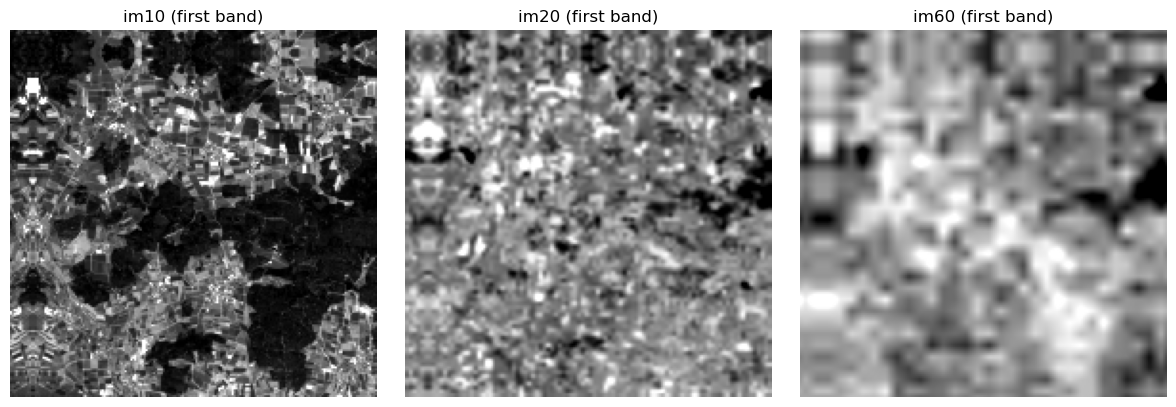

torch.Size([1, 6, 192, 192]) torch.Size([1, 2, 192, 192])


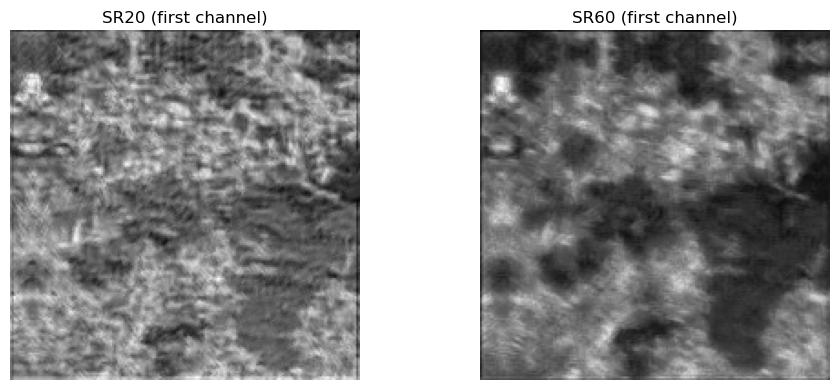

In [33]:
im10, im20, im60 = testimages[0]

# Convert to torch tensors (if not already)
im10 = torch.tensor(im10) if not isinstance(im10, torch.Tensor) else im10
im20 = torch.tensor(im20) if not isinstance(im20, torch.Tensor) else im20
im60 = torch.tensor(im60) if not isinstance(im60, torch.Tensor) else im60

print(f"im10 tensor shape: {im10.shape}")
print(f"im20 tensor shape: {im20.shape}")
print(f"im60 tensor shape: {im60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("im60 (first band)")
plt.imshow(im60[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Insert the image into the model (assuming 'model' is defined and on the correct device)
# Add batch dimension
im10_batch = im10.unsqueeze(0)
im20_batch = im20.unsqueeze(0)
im60_batch = im60.unsqueeze(0)

# Move to device if needed (assuming model.device or 'cuda' if available)
device = next(model.parameters()).device if hasattr(model, 'parameters') else 'cpu'
im10_batch = im10_batch.to(device)
im20_batch = im20_batch.to(device)
im60_batch = im60_batch.to(device)

# Forward pass through the model
with torch.no_grad():
    sr20, sr60 = model(im10_batch, im20_batch, im60_batch)

    print(sr20.shape, sr60.shape)  # Expect [1, 6, 60, 60] and [1, 2, 60, 60]

    # Plot the first channel of sr20 and sr60 as images
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("SR20 (first channel)")
    plt.imshow(sr20[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("SR60 (first channel)")
    plt.imshow(sr60[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# -------------------
# Loss (L1)
# -------------------
loss_fn = nn.L1Loss()

# Updated training function with model saving capabilities
import datetime

# -------------------
# Training loop with early stopping
# -------------------

def train_with_saving(model, train_loader, val_loader, optimizer, stage='sr20', device='cuda', patience=3, save_dir='../results/'):
    import platform
    
    # Check if running on Mac and adapt device accordingly
    if platform.system() == 'Darwin':
        # On Mac, prefer 'mps' if available, else fallback to 'cpu'
        if torch.backends.mps.is_available():
            device = 'mps'
            print("Using Apple MPS device.")
        else:
            device = 'cpu'
            print("Apple MPS not available. Using CPU.")
    elif device == 'cuda' and not torch.cuda.is_available():
        print("CUDA is not available. Switching to CPU.")
        device = 'cpu'
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Generate timestamp for unique model names
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model = model.to(device)
    if stage == 'sr20':
        model.freeze_sr60()
        model.unfreeze_sr20()
    elif stage == 'sr60':
        model.freeze_sr20()
        model.unfreeze_sr60()

    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = f"{save_dir}/best_{stage}_model_{timestamp}.pth"
    
    for epoch in range(1, 23):
        model.train()
        total_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (im10, im20, im60, target20, target60) in enumerate(train_loader, 1):
            im10, im20, im60 = im10.to(device), im20.to(device), im60.to(device)
            target20, target60 = target20.to(device), target60.to(device)

            sr20, sr60 = model(im10, im20, im60)
            loss = loss_fn(sr20, target20) if stage == 'sr20' else loss_fn(sr60, target60)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print echo completion rate
            completion_rate = 100.0 * batch_idx / num_batches
            print(f"\rEpoch {epoch:02d} | Batch {batch_idx}/{num_batches} ({completion_rate:.1f}%)", end='')

        print()  # Newline after epoch's batch progress

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for im10, im20, im60, target20, target60 in val_loader:
                im10, im20, im60 = im10.to(device), im20.to(device), im60.to(device)
                target20, target60 = target20.to(device), target60.to(device)

                sr20, sr60 = model(im10, im20, im60)
                loss = loss_fn(sr20, target20) if stage == 'sr20' else loss_fn(sr60, target60)
                val_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch:02d} | Stage: {stage} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save best model if validation loss improves
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
            
            # Save the best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss,
                'stage': stage,
                'timestamp': timestamp
            }
            torch.save(checkpoint, best_model_path)
            print(f"✅ Best model saved at epoch {epoch} with val_loss: {avg_val_loss:.4f}")
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break
                
        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint_path = f"{save_dir}/checkpoint_{stage}_epoch_{epoch}_{timestamp}.pth"
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'stage': stage,
                'timestamp': timestamp
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"📁 Checkpoint saved: {checkpoint_path}")
    
    # Save final model at the end of training
    final_model_path = f"{save_dir}/final_{stage}_model_{timestamp}.pth"
    final_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_train_loss': avg_train_loss,
        'final_val_loss': avg_val_loss,
        'best_val_loss': best_loss,
        'stage': stage,
        'timestamp': timestamp
    }
    torch.save(final_checkpoint, final_model_path)
    print(f"🎯 Final {stage} model saved: {final_model_path}")
    print(f"⭐ Best {stage} model saved: {best_model_path} (val_loss: {best_loss:.4f})")
    
    return best_model_path, final_model_path


In [33]:
    # Stage 1: Train SR20
dataset = Sentinel2Dataset(dataset_type="20train")
train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)


Loading 20train data from ../data/train
Found 1 samples
Normalizing images...
Normalization complete.


In [34]:
 # Stage 1: Train SR20
optimizer1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
train(model, train_loader, val_loader, optimizer1, stage='sr20')

Using Apple MPS device.
Epoch 01 | Batch 99/900 (11.0%)

KeyboardInterrupt: 